In [51]:
import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

## Helper files

In [20]:
# Get image numbers from train_images/authentic
authentic_path = "data/train_images/authentic"
authentic_files = glob.glob(os.path.join(authentic_path, "*.png"))
authentic_nums = np.array(sorted([int(os.path.basename(f).replace(".png", "")) for f in authentic_files]))

# Get image numbers from train_images/forged
forged_path = "data/train_images/forged"
forged_files = glob.glob(os.path.join(forged_path, "*.png"))
forged_nums = np.array(sorted([int(os.path.basename(f).replace(".png", "")) for f in forged_files]))

# Get image numbers from supplemental_images
supplemental_path = "data/supplemental_images"
supplemental_files = glob.glob(os.path.join(supplemental_path, "*.png"))
supplemental_nums = np.array(sorted([int(os.path.basename(f).replace(".png", "")) for f in supplemental_files]))

print(f"Authentic images: {len(authentic_nums)}")
print(f"Forged images: {len(forged_nums)}")
print(f"Supplemental images: {len(supplemental_nums)}")

Authentic images: 2377
Forged images: 2751
Supplemental images: 48


In [33]:
# Forgery Mask Visualizer
def visualize_forgery_mask(img_num, train):
    """
    Summary:
        Visualize the forgery mask of an image
    Args:
        img_num (int): Image number
        train (boolean): If True, from train_images/forged, otherwise from supplemental_images
    """
    if train:
        img_path = f"data/train_images/forged/{img_num}.png"
        mask_path = f"data/train_masks/{img_num}.npy"
    else:
        img_path = f"data/supplemental_images/{img_num}.png"
        mask_path = f"data/supplemental_masks/{img_num}.npy"

    # Load image
    img = np.array(Image.open(img_path).convert("RGB"))
    H, W = img.shape[:2]

    # Load mask and drop the leading 1
    mask = np.load(mask_path)          # (1, 512, 648)
    mask = mask[0]                     # (512, 648)

    # Binary mask
    mask_bin = (mask > 0).astype(np.uint8)

    # Create red overlay on forged pixels
    overlay = img.copy()
    overlay[mask_bin == 1] = [255, 0, 0]

    # Blend for transparency
    alpha = 0.4
    blended = (alpha * overlay + (1 - alpha) * img).astype(np.uint8)

    plt.figure(figsize=(8, 8))
    plt.imshow(blended)
    plt.axis("off")
    if train:
        plt.title(f"data/train_images/forged/{img_num}.png with mask overlay")
    else:
        plt.title(f"data/supplemental_images/forged/{img_num}.png with mask overlay")
    plt.show()

## AutoEncoder (Why not)

In [61]:
class AuthenticDatasetAE(Dataset):
    """
    Dataset for training an autoencoder on authentic images only.
    Only includes images that are already square (width == height).
    """
    def __init__(self, root_dir, image_size=256):
        """
        root_dir: path to data/train_images/authentic
        """
        all_paths = sorted(glob.glob(os.path.join(root_dir, "*.png")))

        square_paths = []
        for p in all_paths:
            try:
                with Image.open(p) as img:
                    w, h = img.size
                    if w == h:
                        square_paths.append(p)
            except:
                pass

        self.image_paths = square_paths
        print(f"Loaded {len(self.image_paths)} square images out of {len(all_paths)} total.")

        self.transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        x = self.transform(img)
        return x

    def getpaths(self):
        return self.image_paths
    
    def getnums(self):
        return np.array([int(os.path.basename(f).replace(".png", "")) for f in self.image_paths])
    


In [ ]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.enc = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),   # 16 x 128 x 128

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),   # 32 x 64 x 64

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),   # 64 x 32 x 32
        )

        # Decoder
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # 32 x 64 x 64
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),  # 16 x 128 x 128
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2),   # 3 x 256 x 256
            nn.Sigmoid(),  # output in [0,1]
        )

    def forward(self, x):
        z = self.enc(x)
        out = self.dec(z)
        return out


In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_root = "data/train_images/authentic"

dataset = AuthenticDatasetAE(train_root, image_size=256)
loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0)

model = ConvAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


Loaded 528 square images out of 2377 total.


In [64]:
num_epochs = 20  # adjust as needed

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch in loader:
        batch = batch.to(device)

        optimizer.zero_grad()
        recon = model(batch)
        loss = criterion(recon, batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * batch.size(0)

    epoch_loss = running_loss / len(dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - loss: {epoch_loss:.6f}")


Epoch 1/20 - loss: 0.107804
Epoch 2/20 - loss: 0.011303
Epoch 3/20 - loss: 0.007360
Epoch 4/20 - loss: 0.006060
Epoch 5/20 - loss: 0.005568
Epoch 6/20 - loss: 0.005286
Epoch 7/20 - loss: 0.005476
Epoch 8/20 - loss: 0.004974
Epoch 9/20 - loss: 0.005229
Epoch 10/20 - loss: 0.004658
Epoch 11/20 - loss: 0.004813
Epoch 12/20 - loss: 0.004373
Epoch 13/20 - loss: 0.004615
Epoch 14/20 - loss: 0.004252
Epoch 15/20 - loss: 0.003758
Epoch 16/20 - loss: 0.003478
Epoch 17/20 - loss: 0.003289
Epoch 18/20 - loss: 0.002829
Epoch 19/20 - loss: 0.002668
Epoch 20/20 - loss: 0.002560


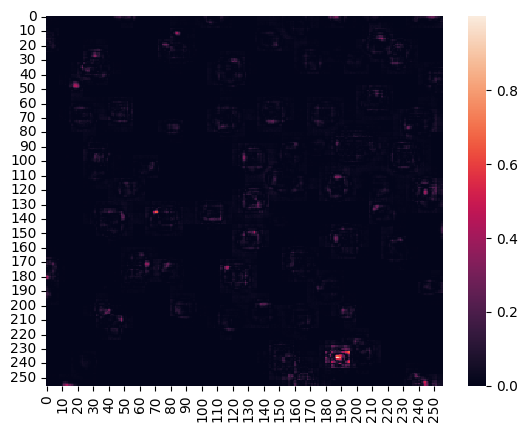

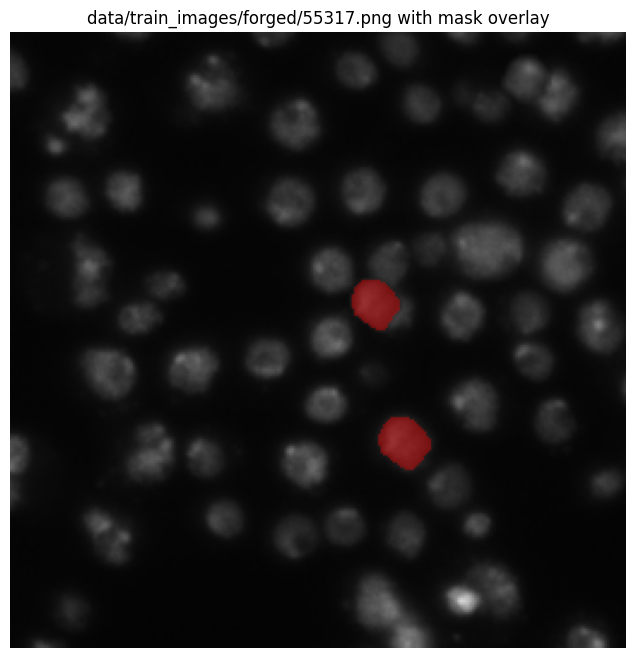

In [129]:
from torchvision.transforms.functional import to_tensor, resize
import seaborn as sns

model.eval()

num = np.random.choice(dataset.getnums())
img_path = f"data/train_images/forged/{num}.png"
img_pil = Image.open(img_path).convert("RGB")
img_resized = img_pil.resize((256, 256))
x = to_tensor(img_resized).unsqueeze(0).to(device)  # (1,3,256,256)

with torch.no_grad():
    recon = model(x)

# Per-pixel squared error
err_map = (x - recon).pow(2).mean(dim=1).squeeze(0).cpu().numpy()  # shape (256,256)

# Normalize for visualization
err_norm = (err_map - err_map.min()) / (err_map.max() - err_map.min() + 1e-8)

sns.heatmap(err_norm)
visualize_forgery_mask(num, train=True)
